# Portuguese Phonetic Lexicon — Full Dataset Analysis

Dataset: `TigreGotico/portuguese_phonetic_lexicon`  
617k rows · columns: `id`, `word`, `postag`, `gender`, `phones`, `syllables`, `region_code`

**What this notebook covers:**
- Dataset overview & schema validation
- Lexicon statistics (word length, syllable count, phone inventory)
- POS tag distribution
- Gender distribution
- Regional variation analysis (phone divergence across 10 dialects)
- IPA phone & phoneme inventory analysis
- Grapheme-to-phoneme (G2P) consistency metrics
- Stress pattern analysis
- Syllable structure & complexity
- Cross-regional phone mapping heatmaps
- MLflow experiment tracking

## ⚙️ Configuration

In [1]:
import os

def _env(key, default=""):
    return os.environ.get(key, default)

def _flag(key, default=False):
    v = os.environ.get(key, str(default)).lower()
    return v in ("1", "true", "yes")

# Dataset
REPO_ID          = _env("REPO_ID", "TigreGotico/portuguese_phonetic_lexicon")
SPLIT            = _env("SPLIT", "train")
HF_TOKEN         = _env("HF_TOKEN", None) or None

# MLflow
MLFLOW_TRACKING  = _flag("MLFLOW_TRACKING", True)
MLFLOW_URI       = _env("MLFLOW_URI", "./mlruns")
MLFLOW_EXP       = _env("MLFLOW_EXP", "phonetic_lexicon_analysis")

# HF Upload
HF_UPLOAD        = _flag("HF_UPLOAD", False)
HF_UPLOAD_REPO   = _env("HF_UPLOAD_REPO", "")

# Output
OUTPUT_DIR       = _env("OUTPUT_DIR", "./analysis_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Display
TOP_N            = int(_env("TOP_N", "30"))   # top-N entries in bar charts
FIG_DPI          = int(_env("FIG_DPI", "120"))

print(f"REPO_ID         : {REPO_ID}")
print(f"SPLIT           : {SPLIT}")
print(f"OUTPUT_DIR      : {OUTPUT_DIR}")
print(f"MLFLOW_TRACKING : {MLFLOW_TRACKING}")
print(f"HF_UPLOAD       : {HF_UPLOAD}")

REPO_ID         : TigreGotico/portuguese_phonetic_lexicon
SPLIT           : train
OUTPUT_DIR      : ./analysis_output
MLFLOW_TRACKING : True
HF_UPLOAD       : False


## 📦 Dependencies

In [2]:
!pip install -q datasets pandas matplotlib seaborn mlflow huggingface_hub scipy --break-system-packages

## 📥 Load Dataset

In [3]:
import pandas as pd
import numpy as np
from datasets import load_dataset

CACHE_PATH = os.path.join(OUTPUT_DIR, "lexicon_cache.parquet")

if os.path.exists(CACHE_PATH):
    print(f"Loading from cache: {CACHE_PATH}")
    df = pd.read_parquet(CACHE_PATH)
else:
    print(f"Downloading {REPO_ID} ...")
    ds = load_dataset(REPO_ID, split=SPLIT, token=HF_TOKEN)
    df = ds.to_pandas()
    df.to_parquet(CACHE_PATH, index=False)
    print(f"Cached to {CACHE_PATH}")

print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head(3)

/home/miro/PycharmProjects/wakeHuBert/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Cached to ./analysis_output/lexicon_cache.parquet
Shape: (616716, 7)
Columns: ['id', 'word', 'postag', 'gender', 'phones', 'syllables', 'region_code']


,id,word,postag,gender,phones,syllables,region_code
0,a_DET_mpx,a,DET,None,ɐ,a,mpx
1,a_ADP_mpx,a,ADP,None,ɐ,a,mpx
2,a_DET_lda,a,DET,None,a,a,lda


## 🔍 Schema Validation & Basic Stats

In [4]:
print("=== dtypes ===")
print(df.dtypes)
print("\n=== null counts ===")
print(df.isnull().sum())
print("\n=== sample counts ===")
print(f"Total rows        : {len(df):,}")
print(f"Unique words      : {df['word'].nunique():,}")
print(f"Unique POSTags    : {df['postag'].nunique()}")
print(f"Unique regions    : {df['region_code'].nunique()}")
print(f"Unique phone seqs : {df['phones'].nunique():,}")
print(f"Rows with gender  : {df['gender'].notna().sum():,}")

=== dtypes ===
id             object
word           object
postag         object
gender         object
phones         object
syllables      object
region_code    object
dtype: object

=== null counts ===
id                  0
word                0
postag              0
gender         285193
phones              0
syllables           0
region_code         0
dtype: int64

=== sample counts ===
Total rows        : 616,716
Unique words      : 53,349
Unique POSTags    : 10
Unique regions    : 10
Unique phone seqs : 358,017
Rows with gender  : 331,523


## 📊 MLflow Setup

In [5]:
import mlflow
import mlflow.data

if MLFLOW_TRACKING:
    mlflow.set_tracking_uri(MLFLOW_URI)
    mlflow.set_experiment(MLFLOW_EXP)
    run = mlflow.start_run(run_name="full_analysis")
    mlflow.log_params({
        "repo_id": REPO_ID,
        "split": SPLIT,
        "total_rows": len(df),
        "unique_words": df['word'].nunique(),
        "unique_regions": df['region_code'].nunique(),
    })
    print(f"MLflow run: {run.info.run_id}")
else:
    print("MLflow tracking disabled.")

2026/02/19 01:15:09 INFO mlflow.tracking.fluent: Experiment with name 'phonetic_lexicon_analysis' does not exist. Creating a new experiment.


MLflow run: 9487bfec222a40d0887c7d2e6581185e


## 🧹 Feature Engineering

In [34]:

df['phonemes'] = df['phones'].apply(lambda x: list(str(x).replace('|', "")) if pd.notna(x) else 0)

# Word length (characters)
df['word_len'] = df['word'].str.len()

# Syllable count (pipe-separated)
df['syll_count'] = df['syllables'].apply(lambda x: len(str(x).split('|')) if pd.notna(x) else 0)

# Phone count (pipe-separated)
df['phone_count'] = df['phones'].apply(lambda x: len(str(x).split('|')) if pd.notna(x) else 0)
df['phoneme_count'] =df['phones'].apply(lambda x: len(str(x).replace("|", "").split()) if pd.notna(x) else 0)

# Stress markers: primary ˈ, secondary ˌ
df['has_primary_stress']   = df['phones'].str.contains('ˈ', na=False)
df['has_secondary_stress'] = df['phones'].str.contains('ˌ', na=False)
df['stress_count'] = (
    df['phones'].str.count('ˈ').fillna(0) +
    df['phones'].str.count('ˌ').fillna(0)
).astype(int)

# Phones per syllable ratio
df['phones_per_syll'] = np.where(
    df['syll_count'] > 0,
    df['phone_count'] / df['syll_count'],
    np.nan
)
df['phonemes_per_syll'] = np.where(
    df['syll_count'] > 0,
    df['phoneme_count'] / df['syll_count'],
    np.nan
)

# Word initial phone
df['initial_phone'] = df['phones'].str.split('|').str[0]

# Word final phone
df['final_phone'] = df['phones'].str.split('|').str[-1]

print("Feature engineering done.")
df[['word','postag','region_code','word_len','syll_count','phone_count','phoneme_count','stress_count']].head(5)

Feature engineering done.


,word,postag,region_code,word_len,syll_count,phone_count,phoneme_count,stress_count
0,a,DET,mpx,1,1,1,1,0
1,a,ADP,mpx,1,1,1,1,0
2,a,DET,lda,1,1,1,1,0
3,a,ADP,lda,1,1,1,1,0
4,a,DET,rjo,1,1,1,1,0


## 📈 Section 1 — Word & Lexicon Statistics

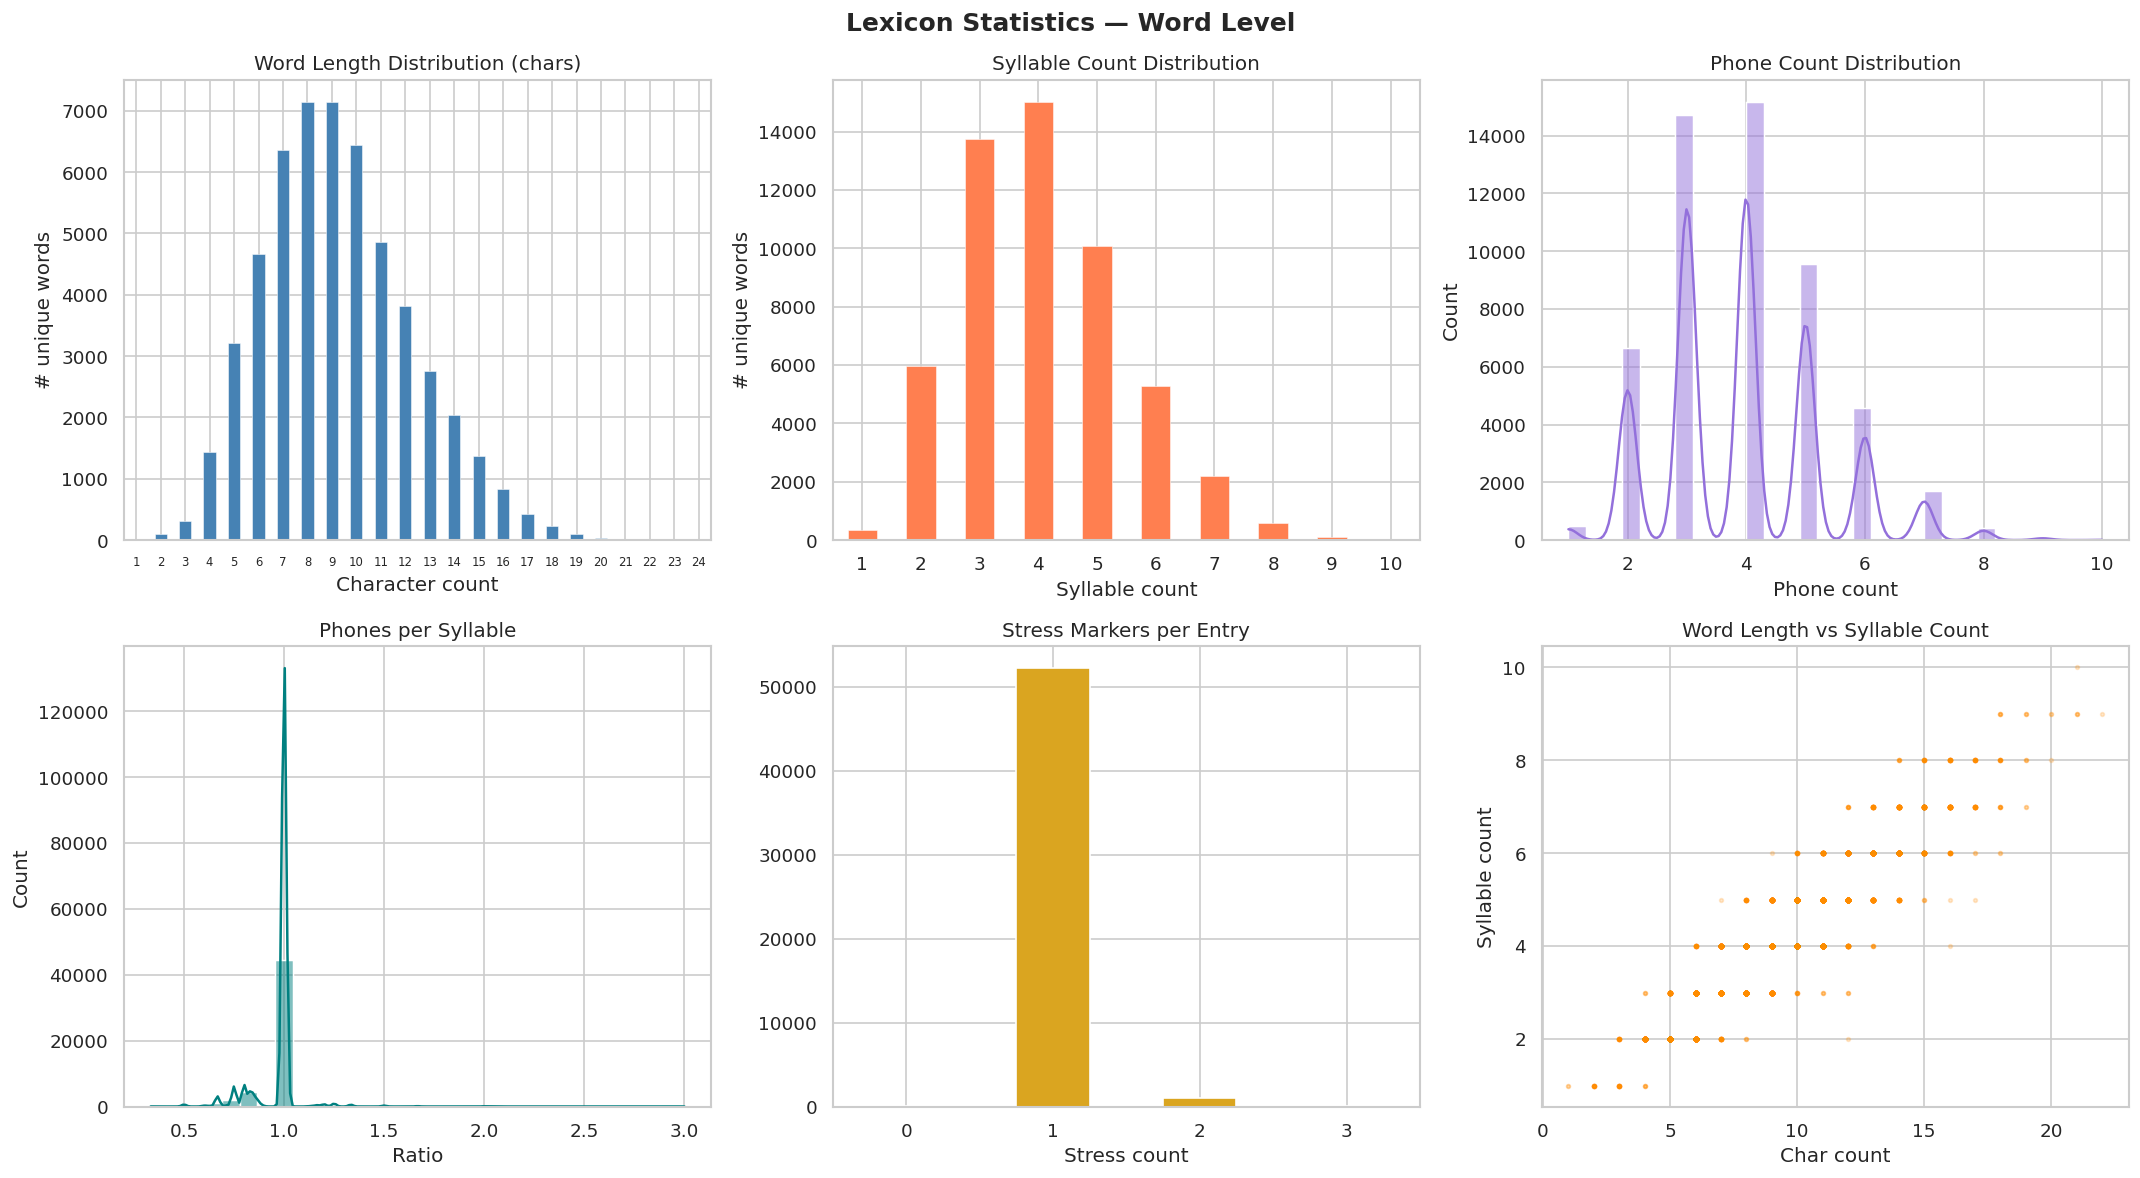

Saved: ./analysis_output/01_lexicon_stats.png


In [36]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.dpi'] = FIG_DPI

# Use unique words only for lexical stats
words_df = df.groupby('word').first().reset_index()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Lexicon Statistics — Word Level', fontsize=15, fontweight='bold')

# 1. Word length distribution
ax = axes[0,0]
words_df['word_len'].value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue', edgecolor='white', linewidth=0.3)
ax.set_title('Word Length Distribution (chars)')
ax.set_xlabel('Character count')
ax.set_ylabel('# unique words')
ax.tick_params(axis='x', rotation=0, labelsize=7)

# 2. Syllable count distribution
ax = axes[0,1]
words_df['syll_count'].value_counts().sort_index().plot(kind='bar', ax=ax, color='coral', edgecolor='white', linewidth=0.3)
ax.set_title('Syllable Count Distribution')
ax.set_xlabel('Syllable count')
ax.set_ylabel('# unique words')
ax.tick_params(axis='x', rotation=0)

# 3. Phone count distribution
ax = axes[0,2]
sns.histplot(words_df['phone_count'], bins=30, ax=ax, color='mediumpurple', kde=True)
ax.set_title('Phone Count Distribution')
ax.set_xlabel('Phone count')

# 4. Phones per syllable
ax = axes[1,0]
sns.histplot(words_df['phones_per_syll'].dropna(), bins=30, ax=ax, color='teal', kde=True)
ax.set_title('Phones per Syllable')
ax.set_xlabel('Ratio')

# 5. Stress count distribution
ax = axes[1,1]
words_df['stress_count'].value_counts().sort_index().plot(kind='bar', ax=ax, color='goldenrod', edgecolor='white')
ax.set_title('Stress Markers per Entry')
ax.set_xlabel('Stress count')
ax.tick_params(axis='x', rotation=0)

# 6. word_len vs syll_count scatter
ax = axes[1,2]
sample = words_df.sample(min(5000, len(words_df)), random_state=42)
ax.scatter(sample['word_len'], sample['syll_count'], alpha=0.2, s=5, color='darkorange')
ax.set_title('Word Length vs Syllable Count')
ax.set_xlabel('Char count')
ax.set_ylabel('Syllable count')

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "01_lexicon_stats.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)
print("Saved:", p)

## 📊 Section 2 — POS Tag & Gender Distribution

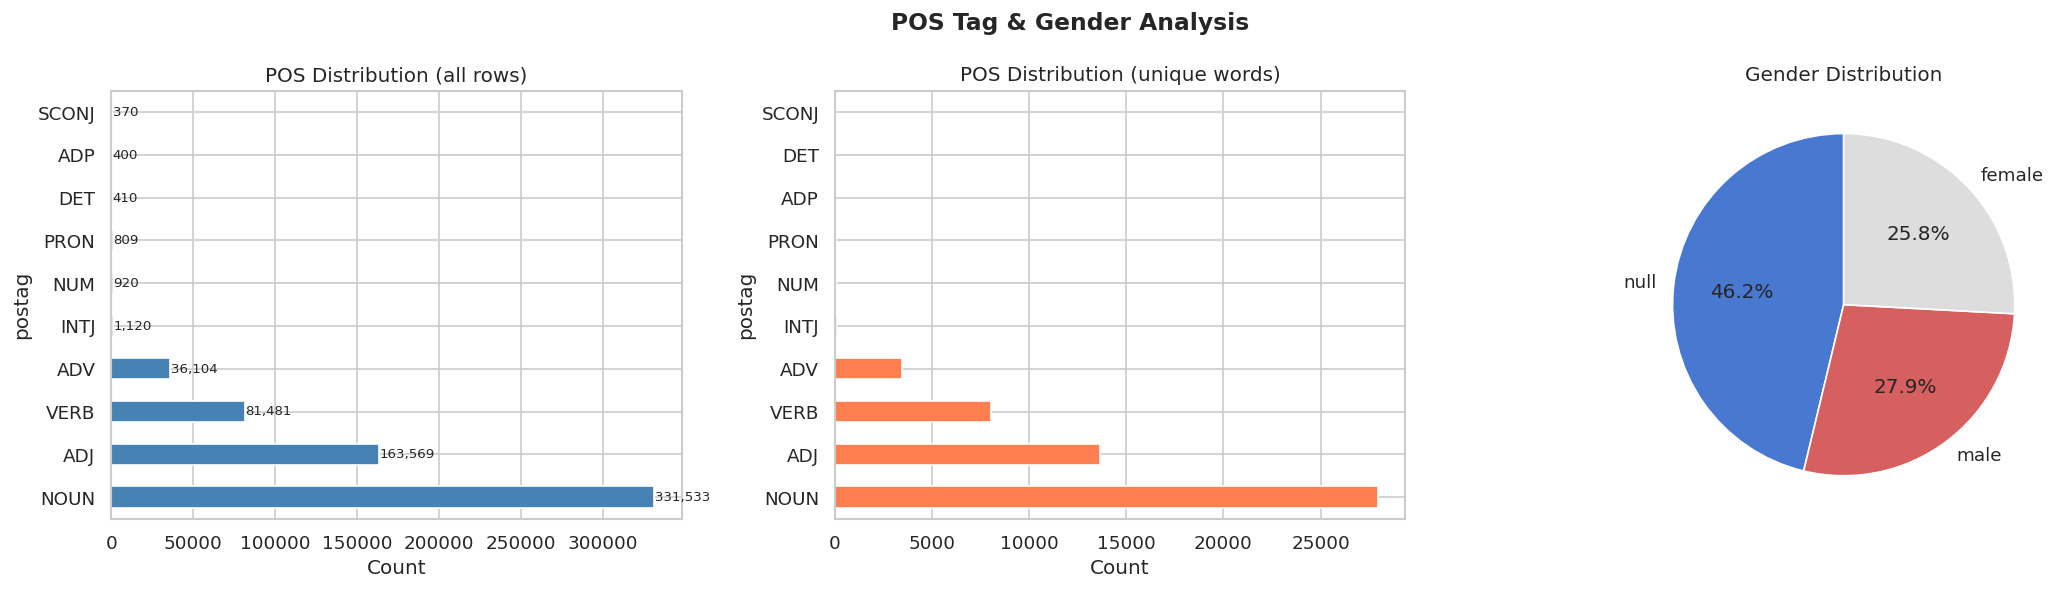

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('POS Tag & Gender Analysis', fontsize=14, fontweight='bold')

# 1. POS distribution (total rows)
pos_counts = df['postag'].value_counts()
ax = axes[0]
pos_counts.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('POS Distribution (all rows)')
ax.set_xlabel('Count')
for bar, val in zip(ax.patches, pos_counts):
    ax.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2,
            f'{val:,}', va='center', fontsize=8)

# 2. POS distribution (unique words)
pos_word = df.drop_duplicates('word')['postag'].value_counts()
ax = axes[1]
pos_word.plot(kind='barh', ax=ax, color='coral')
ax.set_title('POS Distribution (unique words)')
ax.set_xlabel('Count')

# 3. Gender distribution
ax = axes[2]
gender_counts = df['gender'].fillna('null').value_counts()
wedges, texts, autotexts = ax.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    colors=['#4878CF','#D65F5F','#DDDDDD'],
    startangle=90
)
ax.set_title('Gender Distribution')

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "02_pos_gender.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

# Log POS metrics
if MLFLOW_TRACKING:
    for tag, cnt in pos_counts.items():
        mlflow.log_metric(f"pos_{tag}_count", int(cnt))

## 🗺️ Section 3 — Regional Distribution

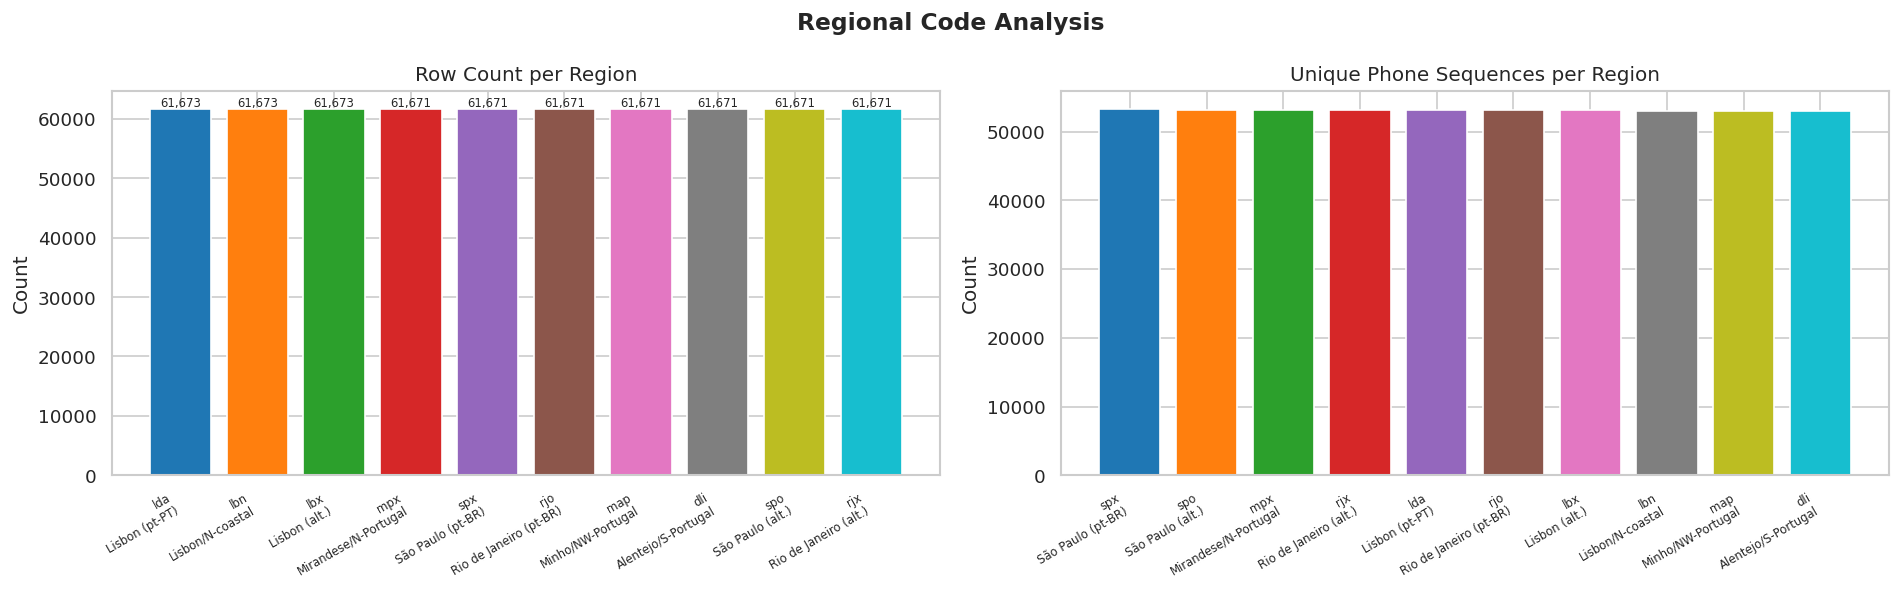

In [9]:
# Region metadata (known codes in dataset)
REGION_NAMES = {
    'mpx': 'Mirandese/N-Portugal',
    'lda': 'Lisbon (pt-PT)',
    'rjo': 'Rio de Janeiro (pt-BR)',
    'spx': 'São Paulo (pt-BR)',
    'lbn': 'Lisbon/N-coastal',
    'map': 'Minho/NW-Portugal',
    'dli': 'Alentejo/S-Portugal',
    'spo': 'São Paulo (alt.)',
    'rjx': 'Rio de Janeiro (alt.)',
    'lbx': 'Lisbon (alt.)',
}

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Regional Code Analysis', fontsize=14, fontweight='bold')

rc = df['region_code'].value_counts()
labels = [f"{code}\n{REGION_NAMES.get(code,'')}" for code in rc.index]

ax = axes[0]
bars = ax.bar(range(len(rc)), rc.values, color=sns.color_palette('tab10', len(rc)))
ax.set_xticks(range(len(rc)))
ax.set_xticklabels(labels, fontsize=7, rotation=30, ha='right')
ax.set_title('Row Count per Region')
ax.set_ylabel('Count')
for bar, val in zip(bars, rc.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
            f'{val:,}', ha='center', fontsize=7)

# Unique phone sequences per region
ax = axes[1]
uniq_phones = df.groupby('region_code')['phones'].nunique().sort_values(ascending=False)
uniq_labels = [f"{code}\n{REGION_NAMES.get(code,'')}" for code in uniq_phones.index]
bars2 = ax.bar(range(len(uniq_phones)), uniq_phones.values, color=sns.color_palette('tab10', len(uniq_phones)))
ax.set_xticks(range(len(uniq_phones)))
ax.set_xticklabels(uniq_labels, fontsize=7, rotation=30, ha='right')
ax.set_title('Unique Phone Sequences per Region')
ax.set_ylabel('Count')

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "03_regional.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 🔤 Section 4 — IPA Phone Inventory

In [10]:
from collections import Counter

def extract_phones(phones_series):
    """Flatten all pipe-separated phone sequences into a single list of phones."""
    phones = []
    for entry in phones_series.dropna():
        phones.extend(str(entry).split('|'))
    return phones

# Strip stress markers to get base phones
def strip_stress(phone):
    return phone.replace('ˈ', '').replace('ˌ', '').strip()

all_phones_raw  = extract_phones(df['phones'])
all_phones_base = [strip_stress(p) for p in all_phones_raw if strip_stress(p)]

phone_freq = Counter(all_phones_base)
top_phones = phone_freq.most_common(TOP_N)

print(f"Total phone tokens  : {len(all_phones_raw):,}")
print(f"Unique phone types  : {len(set(all_phones_base))}")
print(f"\nTop 20 phones:")
for ph, cnt in phone_freq.most_common(20):
    print(f"  {ph:10s}  {cnt:>8,}")

Total phone tokens  : 2,401,533
Unique phone types  : 8590

Top 20 phones:
  ti            39,183
  a             37,361
  si            30,582
  dʊ            29,387
  li            29,121
  ĩ            26,999
  ɐ             26,451
  tɐ            26,348
  mẽ           26,074
  tɨ            21,758
  mi            21,732
  ta            21,604
  kɐ            20,867
  tʃi           20,734
  du            20,162
  ni            19,843
  de            19,746
  ka            18,949
  ku            18,925
  tu            18,711


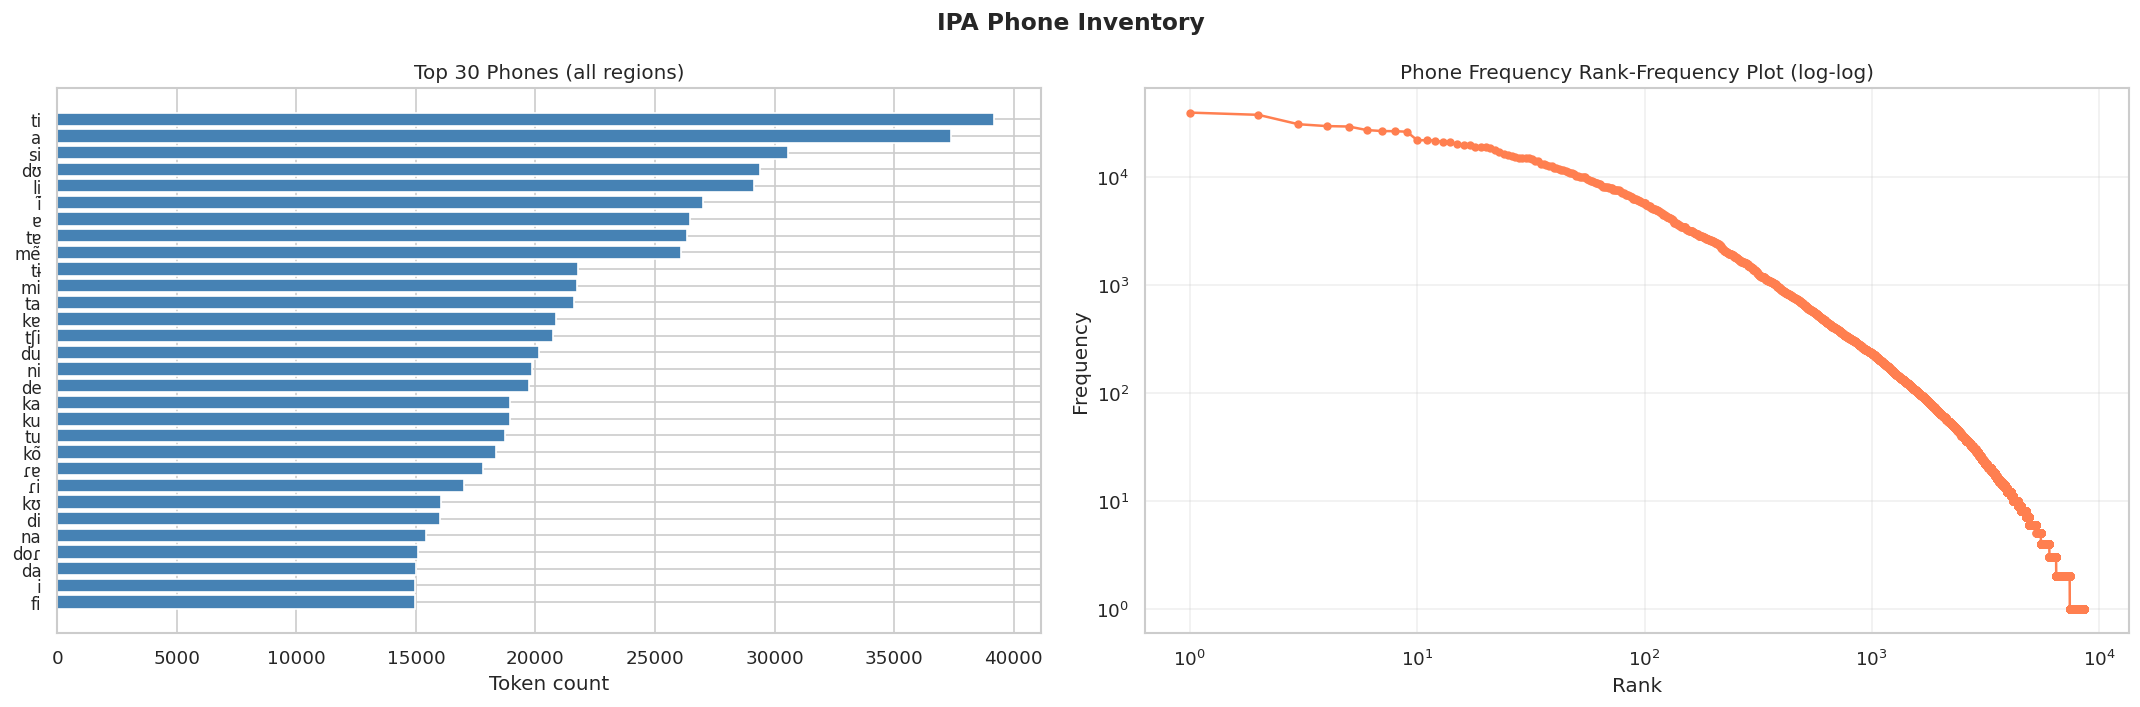

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('IPA Phone Inventory', fontsize=14, fontweight='bold')

# Top-N phones overall
ax = axes[0]
phones_, cnts_ = zip(*top_phones)
ax.barh(phones_[::-1], cnts_[::-1], color='steelblue')
ax.set_title(f'Top {TOP_N} Phones (all regions)')
ax.set_xlabel('Token count')
ax.tick_params(axis='y', labelsize=10)

# Log-scale frequency rank plot (Zipf check)
ax = axes[1]
ranks = range(1, len(phone_freq)+1)
freqs = [v for _, v in phone_freq.most_common()]
ax.loglog(ranks, freqs, 'o-', markersize=4, color='coral')
ax.set_title('Phone Frequency Rank-Frequency Plot (log-log)')
ax.set_xlabel('Rank')
ax.set_ylabel('Frequency')
ax.grid(True, alpha=0.3)

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "04_phone_inventory.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING:
    mlflow.log_artifact(p)
    mlflow.log_metric("unique_phones", len(set(all_phones_base)))
    mlflow.log_metric("total_phone_tokens", len(all_phones_raw))

## 🌍 Section 5 — Regional Phone Variation

In [12]:
# Build per-region phone frequency vectors
regions = sorted(df['region_code'].unique())
region_phone_freq = {}
for region in regions:
    region_phones = extract_phones(df[df['region_code'] == region]['phones'])
    region_phone_freq[region] = Counter([strip_stress(p) for p in region_phones if strip_stress(p)])

# Phones that appear in all regions
common_phones = set(region_phone_freq[regions[0]].keys())
for r in regions[1:]:
    common_phones &= set(region_phone_freq[r].keys())

print(f"Phones in ALL regions: {len(common_phones)}")

# Phones exclusive to specific regions
for region in regions:
    others = set()
    for r2 in regions:
        if r2 != region:
            others |= set(region_phone_freq[r2].keys())
    exclusive = set(region_phone_freq[region].keys()) - others
    if exclusive:
        print(f"  Exclusive to {region}: {sorted(exclusive)}")

Phones in ALL regions: 378
  Exclusive to dli: ['aɾtʰ', 'baʃtʰ', 'bẽm', 'bẽntʰ', 'bjãntʰ', 'bjər', 'bjəɫ', 'bjəʃ', 'blãntʰ', 'bleɛ', 'bleɛj', 'blẽn', 'bləʃ', 'buʃtʰ', 'bwaw', 'bwĩntʰ', 'bwə̃w', 'bɐ̃jə', 'bɔtʰ', 'bəb', 'bəd', 'bəj', 'bək', 'bəp', 'bər', 'bəw', 'bəɫ', 'bəɾ', 'bəʃ', 'bəʒ', 'bɨr', 'bɾãntʰ', 'bɾetʰ', 'bɾeɛ', 'bɾjãntʰ', 'bɾjə̃w', 'bɾoɔ', 'bɾəj', 'bɾəɫ', 'bɾəʃ', 'bɾɛtʰ', 'daɾtʰ', 'deɛj', 'dẽntʰ', 'dĩntʰ', 'djãm', 'djwe', 'djwək', 'djwəʃ', 'djɔw', 'djəg', 'djək', 'djəɫ', 'djəʃ', 'djə̃w', 'doɔ', 'dõntʰ', 'dwãntʰ', 'dwẽn', 'dwẽntʰ', 'dwəɫ', 'dwəʃ', 'dəj', 'dək', 'dəp', 'dəɫ', 'dəɾ', 'dəʃ', 'dɛʃtʰ', 'dɨr', 'dɾeɛ', 'dɾitʰ', 'dɾjə̃w', 'dɾwaw', 'dɾəw', 'dɾəɾ', 'dɾəʃ', 'eb', 'et', 'eɛ', 'eʃtʰ', 'ẽntʰ', 'faɾtʰ', 'fãntʰ', 'fjəɫ', 'fjə̃w', 'flwẽn', 'flwẽntʰ', 'flək', 'fləw', 'fõntʰ', 'ftə', 'fɐjtʊ', 'fɐjtʰ', 'fɔtʰ', 'fɔɾtʰ', 'fəj', 'fək', 'fər', 'fəw', 'fəɫ', 'fəɾ', 'fəʃ', 'fɨr', 'fɾatʰ', 'fɾãm', 'fɾẽntʰ', 'fɾitʰ', 'fɾjə', 'fɾjəɫ', 'fɾõntʰ', 'fɾutʰ', 'fɾuʃtʰ', 'fɾ

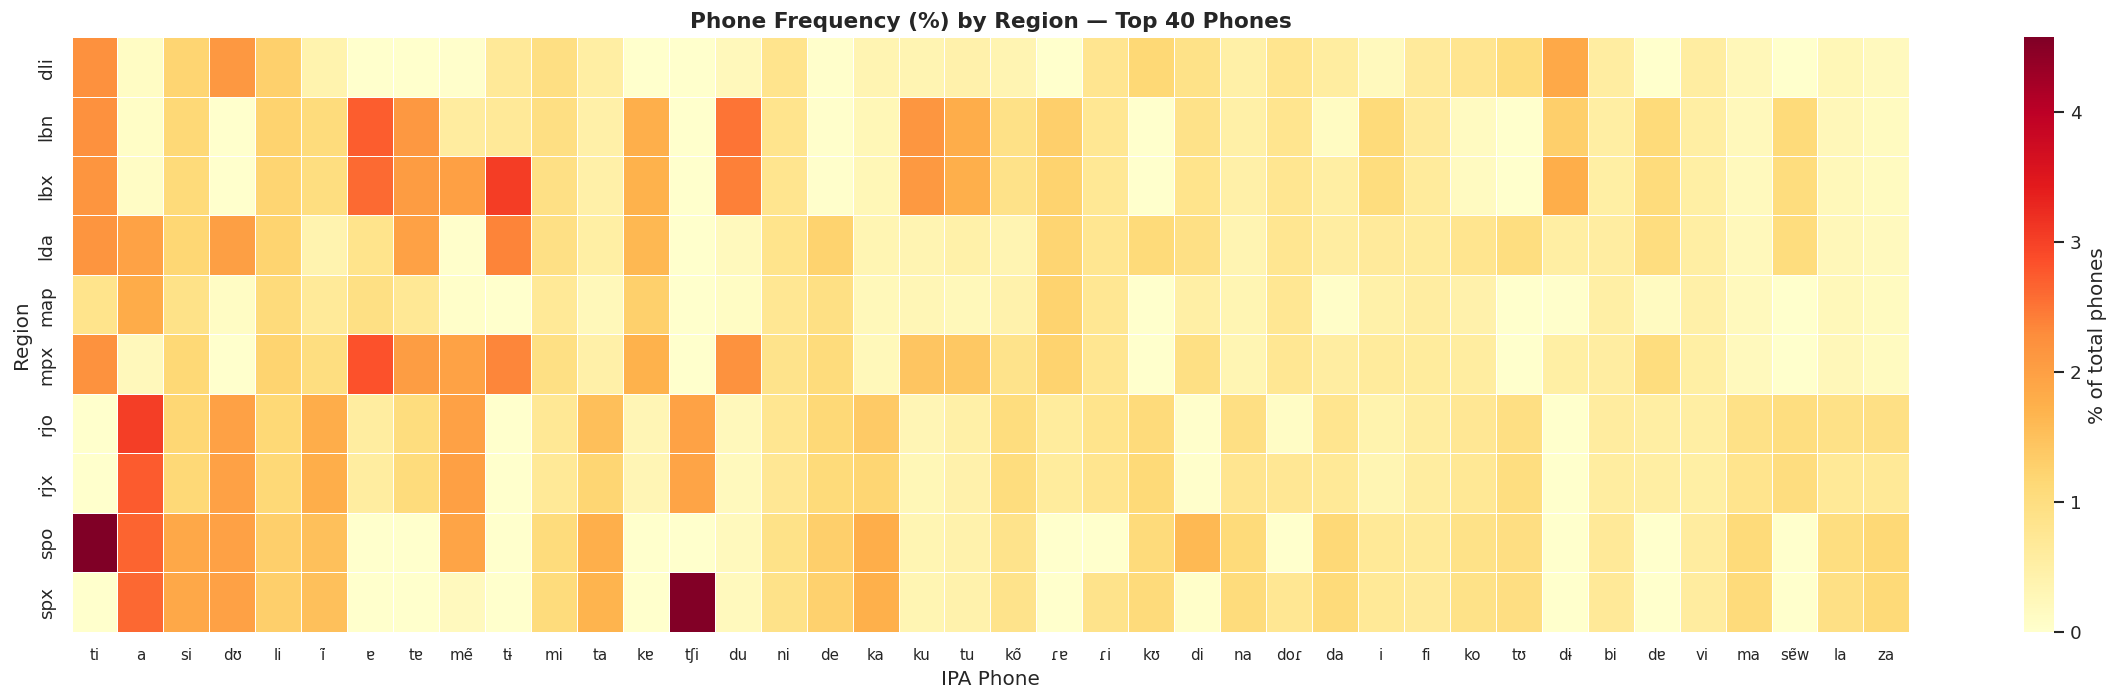

In [13]:
# Regional phone frequency heatmap — top 40 phones
top40 = [p for p, _ in phone_freq.most_common(40)]

matrix = []
for region in regions:
    total = sum(region_phone_freq[region].values())
    row = [region_phone_freq[region].get(ph, 0) / total * 100 for ph in top40]
    matrix.append(row)

heat_df = pd.DataFrame(matrix, index=regions, columns=top40)

fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(heat_df, ax=ax, cmap='YlOrRd', annot=False, fmt='.1f',
            linewidths=0.3, linecolor='white',
            cbar_kws={'label': '% of total phones'})
ax.set_title('Phone Frequency (%) by Region — Top 40 Phones', fontsize=13, fontweight='bold')
ax.set_xlabel('IPA Phone')
ax.set_ylabel('Region')
ax.tick_params(axis='x', labelsize=9)

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "05_regional_phone_heatmap.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 🔀 Section 6 — Cross-Regional Phone Divergence

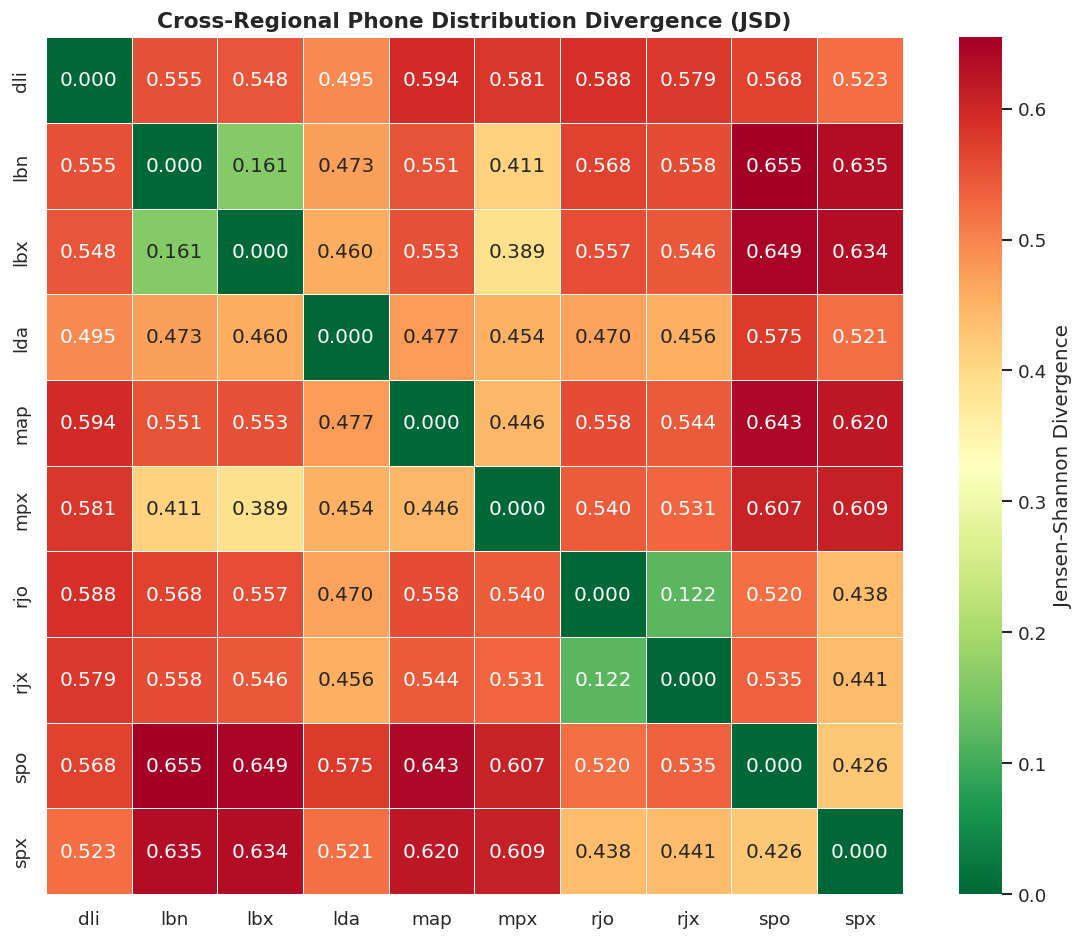

In [14]:
from scipy.spatial.distance import jensenshannon

all_phone_vocab = sorted(set(all_phones_base))
vocab_idx = {p: i for i, p in enumerate(all_phone_vocab)}

def region_vector(region):
    freq = region_phone_freq[region]
    v = np.zeros(len(all_phone_vocab))
    for ph, cnt in freq.items():
        if ph in vocab_idx:
            v[vocab_idx[ph]] = cnt
    total = v.sum()
    return v / total if total > 0 else v

vectors = {r: region_vector(r) for r in regions}

# JSD matrix
jsd_matrix = np.zeros((len(regions), len(regions)))
for i, r1 in enumerate(regions):
    for j, r2 in enumerate(regions):
        jsd_matrix[i, j] = jensenshannon(vectors[r1], vectors[r2])

jsd_df = pd.DataFrame(jsd_matrix, index=regions, columns=regions)

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.zeros_like(jsd_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)  # show diagonal
sns.heatmap(jsd_df, ax=ax, cmap='RdYlGn_r', annot=True, fmt='.3f',
            linewidths=0.5, square=True,
            cbar_kws={'label': 'Jensen-Shannon Divergence'})
ax.set_title('Cross-Regional Phone Distribution Divergence (JSD)', fontsize=13, fontweight='bold')

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "06_jsd_divergence.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING:
    mlflow.log_artifact(p)
    mlflow.log_metric("avg_jsd", float(jsd_matrix[jsd_matrix > 0].mean()))
    mlflow.log_metric("max_jsd", float(jsd_matrix.max()))

## 🔊 Section 7 — Vowel vs Consonant Analysis

Vowel phone types     : 2297
Consonant phone types : 6293


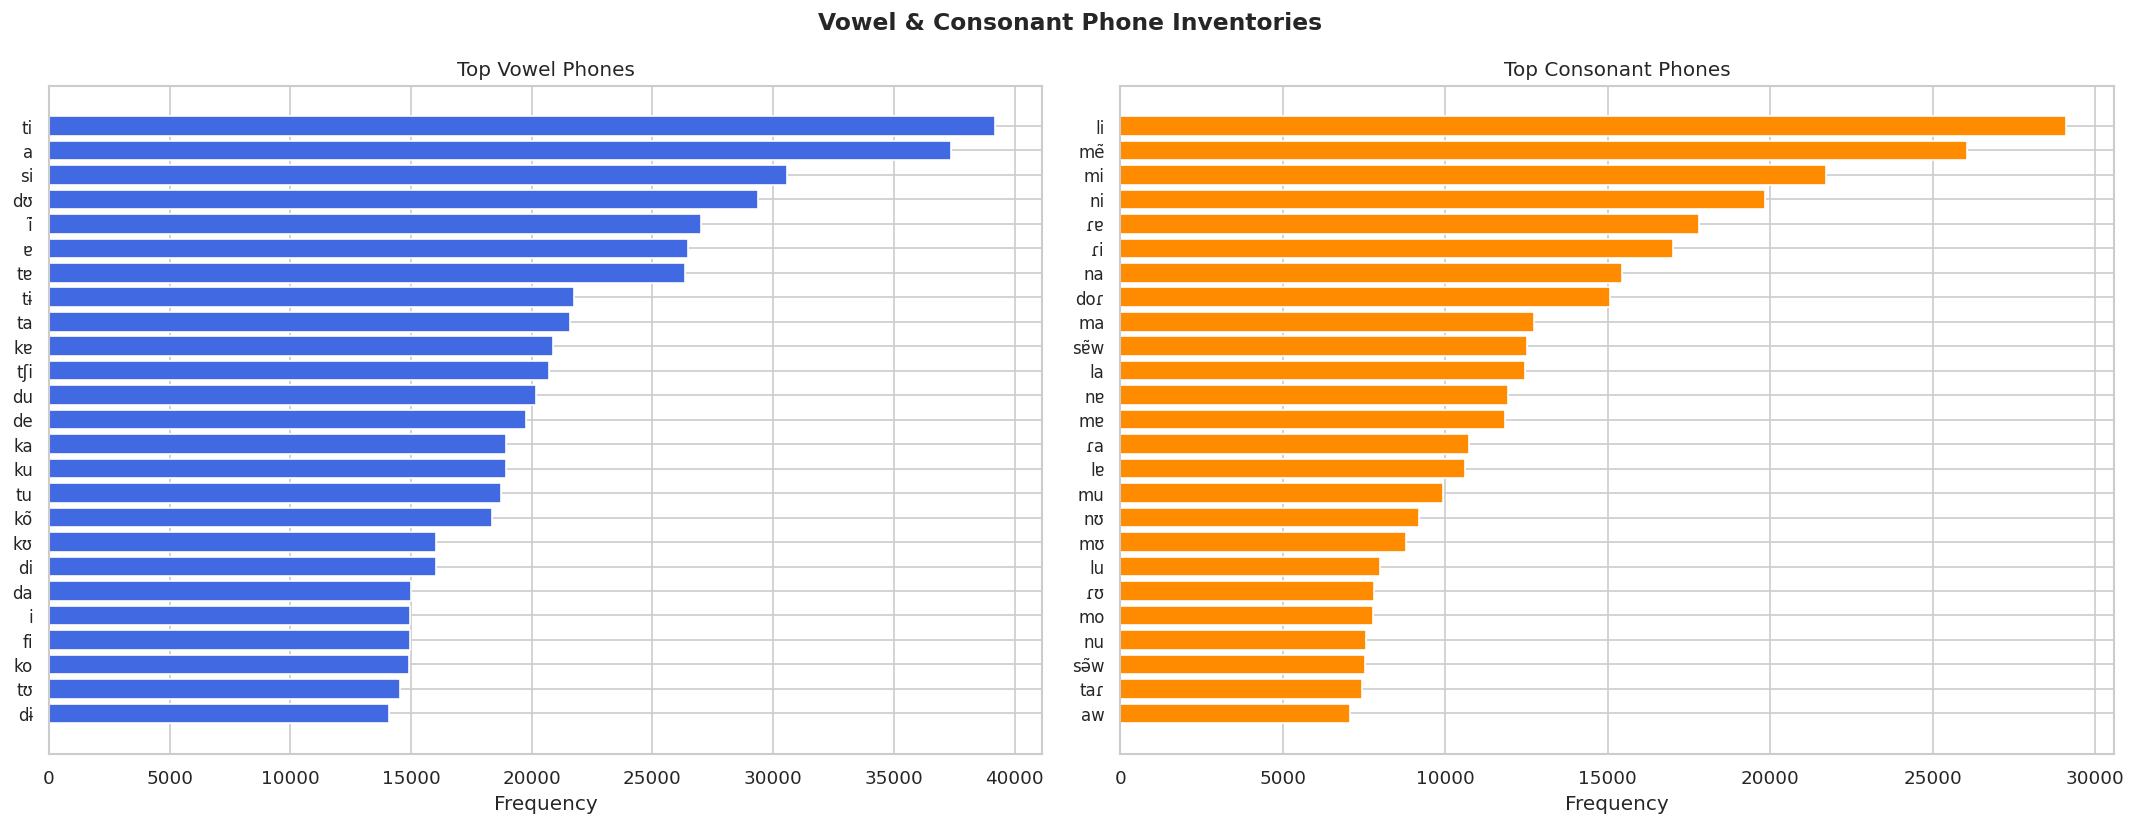

In [15]:
# Portuguese IPA vowels (monophthongs + diphthongs components)
IPA_VOWELS = set([
    'a','e','i','o','u','ɐ','ə','ɛ','ɔ','ɨ','ʊ','ɑ',
    'ẽ','ĩ','õ','ũ','ɐ̃','ã','â','ê','ô',
    'æ','ɪ','ʏ'
])

def is_vowel(ph):
    base = strip_stress(ph)
    # check if any character in phone is a vowel IPA character
    return any(c in IPA_VOWELS for c in base) and not any(c in 'mnlrɾɽʁʀwj' for c in base)

phone_types = {ph: ('vowel' if is_vowel(ph) else 'consonant') for ph in all_phone_vocab}

vowel_phones = {ph: cnt for ph, cnt in phone_freq.items() if phone_types.get(ph) == 'vowel'}
cons_phones  = {ph: cnt for ph, cnt in phone_freq.items() if phone_types.get(ph) == 'consonant'}

print(f"Vowel phone types     : {len(vowel_phones)}")
print(f"Consonant phone types : {len(cons_phones)}")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Vowel & Consonant Phone Inventories', fontsize=14, fontweight='bold')

ax = axes[0]
top_v = sorted(vowel_phones.items(), key=lambda x: -x[1])[:25]
pv, cv = zip(*top_v) if top_v else ([],[])
ax.barh(pv[::-1], cv[::-1], color='royalblue')
ax.set_title('Top Vowel Phones')
ax.set_xlabel('Frequency')
ax.tick_params(axis='y', labelsize=10)

ax = axes[1]
top_c = sorted(cons_phones.items(), key=lambda x: -x[1])[:25]
pc, cc = zip(*top_c) if top_c else ([],[])
ax.barh(pc[::-1], cc[::-1], color='darkorange')
ax.set_title('Top Consonant Phones')
ax.set_xlabel('Frequency')
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "07_vowels_consonants.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 🎯 Section 8 — Stress Pattern Analysis

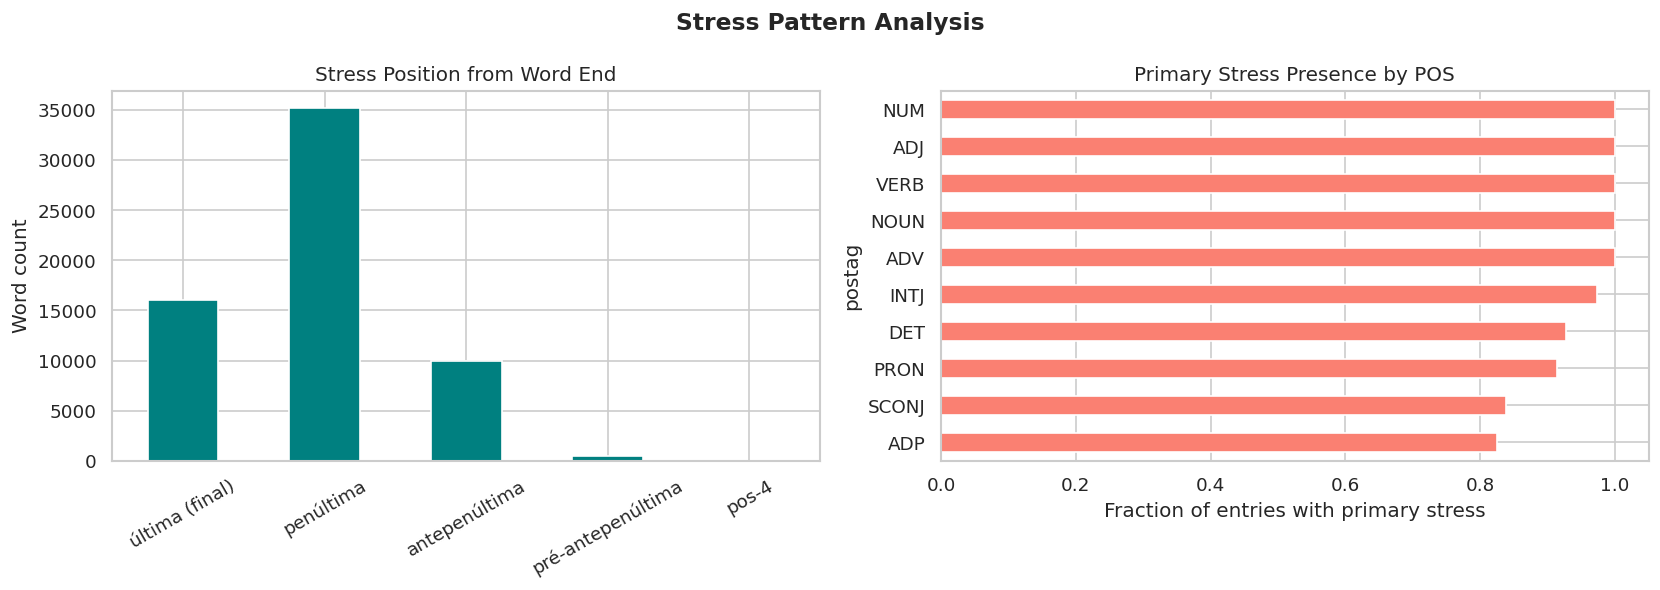

In [16]:
# Position of primary stress within syllable sequence (0-indexed)
def stress_position(phones_str, syllables_str):
    """Return position of stressed syllable (0=first, -1=last, None if no stress)."""
    if pd.isna(phones_str) or pd.isna(syllables_str):
        return None
    sylls = str(syllables_str).split('|')
    n = len(sylls)
    phones_list = str(phones_str).split('|')
    for i, ph in enumerate(phones_list):
        if 'ˈ' in ph:
            return i  # phone index (approximates syllable position)
    return None

# Work on a per-word basis (use one region per word to avoid duplication)
words_df2 = df[df['region_code'] == df['region_code'].value_counts().idxmax()].copy()

words_df2['stress_pos'] = words_df2.apply(
    lambda r: stress_position(r['phones'], r['syllables']), axis=1
)

# Stress from end (penultimate, final, antepenultimate)
def stress_from_end(row):
    if pd.isna(row['phones']) or pd.isna(row['syllables']):
        return None
    sylls = str(row['syllables']).split('|')
    n = len(sylls)
    pos = row.get('stress_pos')
    if pos is None:
        return None
    from_end = n - 1 - min(pos, n-1)
    return from_end

words_df2['stress_from_end'] = words_df2.apply(stress_from_end, axis=1)

stress_pos_label = {
    0: 'última (final)',
    1: 'penúltima',
    2: 'antepenúltima',
    3: 'pré-antepenúltima',
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Stress Pattern Analysis', fontsize=14, fontweight='bold')

ax = axes[0]
sfe = words_df2['stress_from_end'].dropna().astype(int).value_counts().sort_index()
sfe.index = [stress_pos_label.get(i, f'pos-{i}') for i in sfe.index]
sfe.plot(kind='bar', ax=ax, color='teal', edgecolor='white')
ax.set_title('Stress Position from Word End')
ax.set_ylabel('Word count')
ax.tick_params(axis='x', rotation=30)

ax = axes[1]
# Stress by POS
stress_by_pos = words_df2.groupby('postag')['has_primary_stress'].mean().sort_values()
stress_by_pos.plot(kind='barh', ax=ax, color='salmon')
ax.set_title('Primary Stress Presence by POS')
ax.set_xlabel('Fraction of entries with primary stress')

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "08_stress_patterns.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 🔡 Section 9 — Syllable Structure Analysis

In [17]:
# Syllable-level phoneme sequences
from collections import Counter

# Extract syllable templates based on V/C patterns
def syllable_vc_template(syll_phones):
    """Given a list of phones in a syllable, return V/C template."""
    template = ''
    for ph in syll_phones:
        ph_clean = strip_stress(ph)
        template += 'V' if is_vowel(ph_clean) else 'C'
    return template if template else '?'

# Process syllable templates
# phones and syllables are both pipe-separated, same number of elements
syll_templates = Counter()
syll_lengths = []

sample_size = min(50000, len(df))
sample_df = df.sample(sample_size, random_state=42)

for _, row in sample_df.iterrows():
    if pd.isna(row['phones']) or pd.isna(row['syllables']):
        continue
    phones_list = str(row['phones']).split('|')
    sylls_list  = str(row['syllables']).split('|')
    if len(phones_list) == len(sylls_list):
        for ph, syll in zip(phones_list, sylls_list):
            # Each phone token maps to one syllable
            tmpl = 'V' if is_vowel(strip_stress(ph)) else 'C'
            syll_lengths.append(len(syll))

# Phone bigrams (co-occurrence of adjacent phones)
phone_bigrams = Counter()
for entry in sample_df['phones'].dropna():
    phones = [strip_stress(p) for p in str(entry).split('|') if strip_stress(p)]
    for i in range(len(phones)-1):
        phone_bigrams[(phones[i], phones[i+1])] += 1

print(f"Top 15 phone bigrams (phone → phone transitions):")
for (p1, p2), cnt in phone_bigrams.most_common(15):
    print(f"  {p1} → {p2} : {cnt:,}")

Top 15 phone bigrams (phone → phone transitions):
  mẽ → tɨ : 566
  mẽ → tʃɪ : 559
  li → da : 313
  da → dɨ : 307
  bi → li : 302
  mẽ → ti : 282
  mẽjn → tɨ : 273
  mẽj → tʃi : 249
  mẽ → tu : 228
  mẽ → tʊ : 228
  li → za : 221
  ta → dʊ : 216
  ti → ku : 212
  ti → kʊ : 202
  liʃ → tɐ : 198


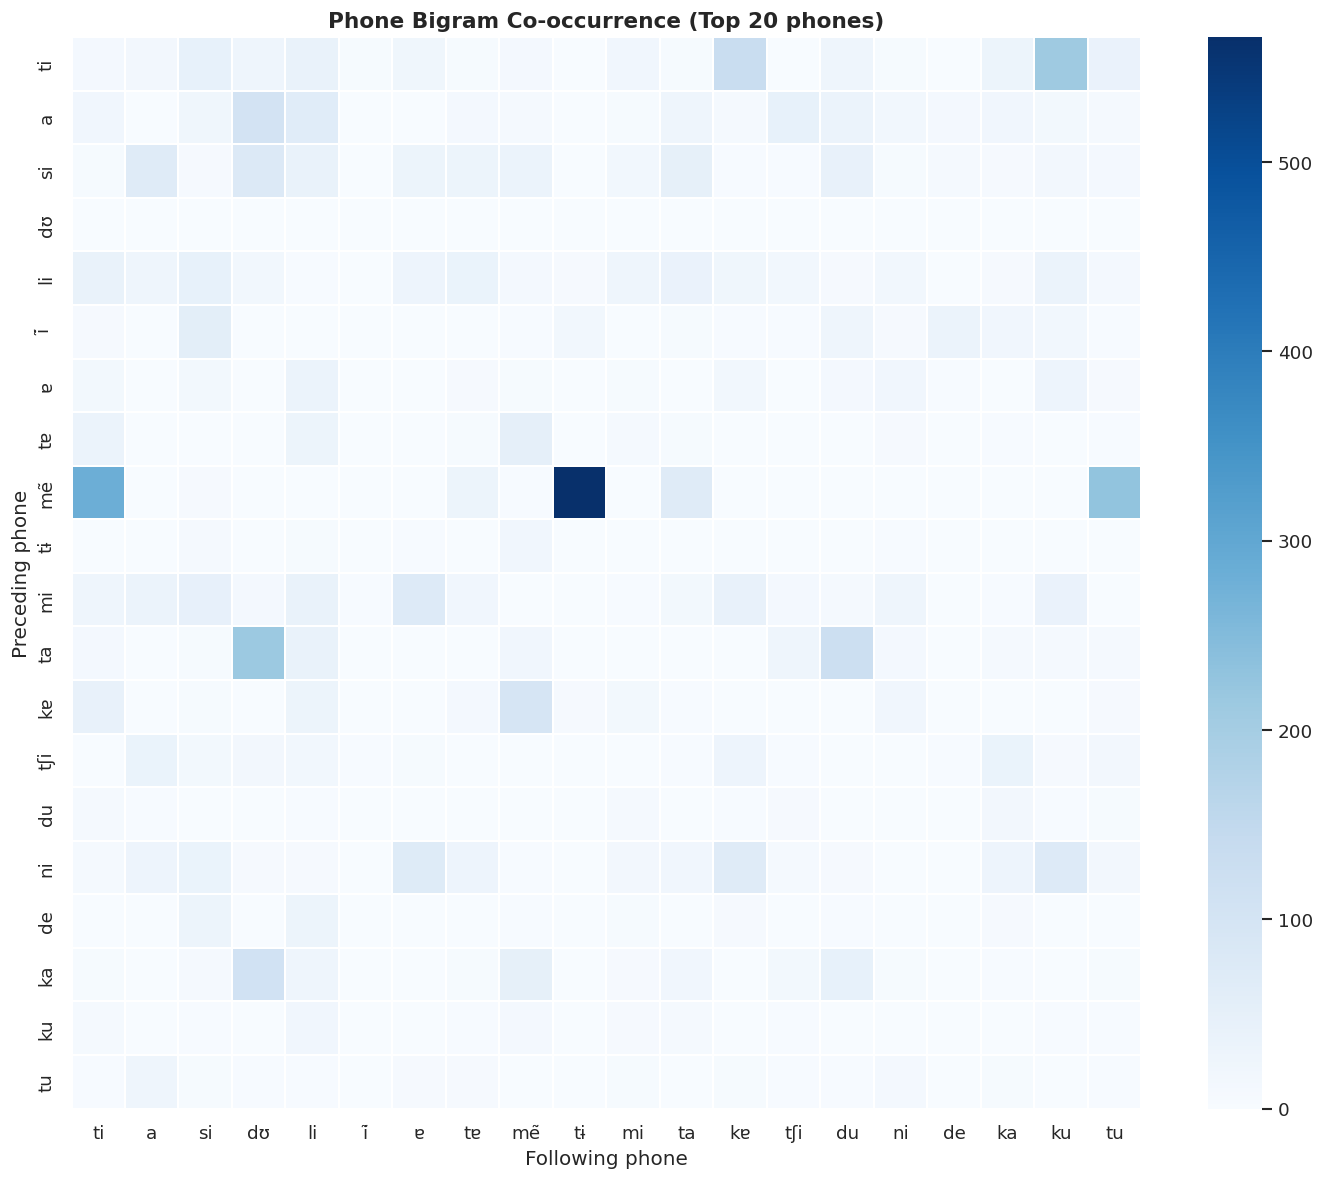

In [18]:
# Bigram heatmap — top 20 phones
top20_phones = [p for p, _ in phone_freq.most_common(20)]
bigram_matrix = np.zeros((20, 20), dtype=int)

for (p1, p2), cnt in phone_bigrams.items():
    if p1 in top20_phones and p2 in top20_phones:
        i, j = top20_phones.index(p1), top20_phones.index(p2)
        bigram_matrix[i, j] = cnt

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    pd.DataFrame(bigram_matrix, index=top20_phones, columns=top20_phones),
    ax=ax, cmap='Blues', annot=False, fmt='d',
    linewidths=0.2, linecolor='white'
)
ax.set_title('Phone Bigram Co-occurrence (Top 20 phones)', fontsize=13, fontweight='bold')
ax.set_xlabel('Following phone')
ax.set_ylabel('Preceding phone')

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "09_phone_bigrams.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 📐 Section 10 — G2P Consistency (Grapheme-to-Phoneme)

In [19]:
# For each unique word, how many distinct phone sequences exist across regions?
g2p_var = df.groupby('word')['phones'].nunique().reset_index()
g2p_var.columns = ['word', 'n_pronunciations']

print("Pronunciation count distribution:")
print(g2p_var['n_pronunciations'].value_counts().sort_index())

pct_consistent = (g2p_var['n_pronunciations'] == 1).mean() * 100
print(f"\nWords with single pronunciation across regions: {pct_consistent:.1f}%")

# Most variable words
top_variable = g2p_var.sort_values('n_pronunciations', ascending=False).head(20)
print("\nMost phonetically variable words:")
print(top_variable.to_string(index=False))

if MLFLOW_TRACKING:
    mlflow.log_metric("pct_single_pronunciation", pct_consistent)
    mlflow.log_metric("max_pronunciations_per_word", int(g2p_var['n_pronunciations'].max()))
    mlflow.log_metric("avg_pronunciations_per_word", float(g2p_var['n_pronunciations'].mean()))

Pronunciation count distribution:
n_pronunciations
1       192
2      1103
3      1961
4      3243
5      5662
6      8283
7     11055
8     14100
9      7137
10      525
11       24
12       14
13       13
14        7
15       10
16        3
17        1
18       15
20        1
Name: count, dtype: int64

Words with single pronunciation across regions: 0.4%

Most phonetically variable words:
                word  n_pronunciations
 superabundantemente                20
     desmarcadamente                18
    desconfiadamente                18
    desgraciosamente                18
     desgostosamente                18
      desveladamente                18
          doidamente                18
   desfavoravelmente                18
  desrespeitosamente                18
desproporcionalmente                18
   desprimorosamente                18
  desconcertadamente                18
           asteroide                18
 despropositadamente                18
                este 

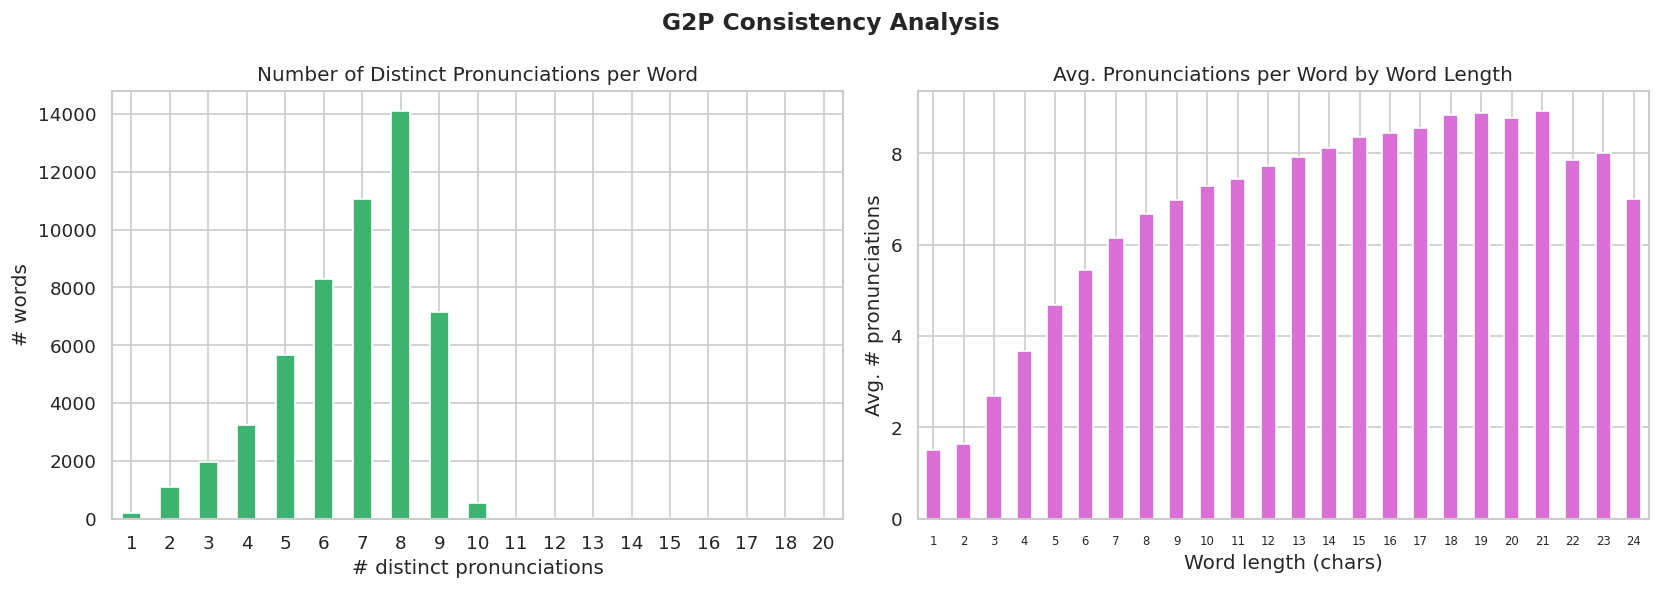

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('G2P Consistency Analysis', fontsize=14, fontweight='bold')

ax = axes[0]
g2p_var['n_pronunciations'].value_counts().sort_index().plot(
    kind='bar', ax=ax, color='mediumseagreen', edgecolor='white'
)
ax.set_title('Number of Distinct Pronunciations per Word')
ax.set_xlabel('# distinct pronunciations')
ax.set_ylabel('# words')
ax.tick_params(axis='x', rotation=0)

# Merge g2p_var with words for additional analysis
ax = axes[1]
merged = words_df.merge(g2p_var, on='word', how='left')
merged.groupby('word_len')['n_pronunciations'].mean().plot(
    kind='bar', ax=ax, color='orchid', edgecolor='white'
)
ax.set_title('Avg. Pronunciations per Word by Word Length')
ax.set_xlabel('Word length (chars)')
ax.set_ylabel('Avg. # pronunciations')
ax.tick_params(axis='x', rotation=0, labelsize=7)

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "10_g2p_consistency.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 📉 Section 11 — POS × Region × Phonetics Interactions

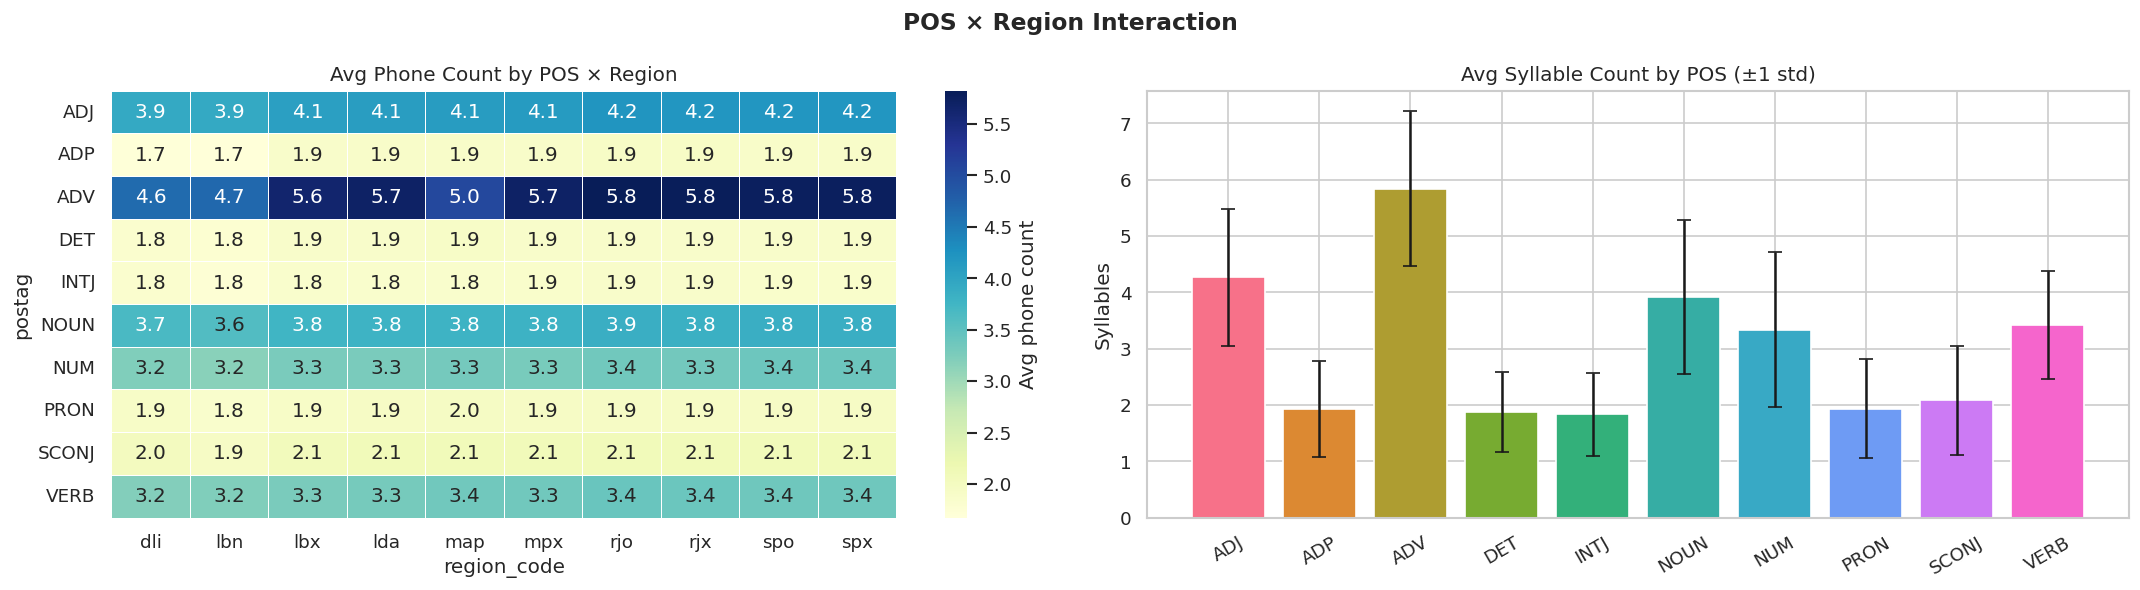

In [21]:
# Average phone count by POS × region
pos_region_phones = df.groupby(['postag','region_code'])['phone_count'].mean().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('POS × Region Interaction', fontsize=14, fontweight='bold')

ax = axes[0]
sns.heatmap(pos_region_phones, ax=ax, cmap='YlGnBu', annot=True, fmt='.1f',
            linewidths=0.3, cbar_kws={'label': 'Avg phone count'})
ax.set_title('Avg Phone Count by POS × Region')

# Syllable count by POS
ax = axes[1]
pos_syll = df.groupby('postag')['syll_count'].agg(['mean','std'])
ax.bar(pos_syll.index, pos_syll['mean'],
       yerr=pos_syll['std'], capsize=4,
       color=sns.color_palette('husl', len(pos_syll)), edgecolor='white')
ax.set_title('Avg Syllable Count by POS (±1 std)')
ax.set_ylabel('Syllables')
ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "11_pos_region_interaction.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 🔠 Section 12 — Word-Initial & Word-Final Phone Distributions

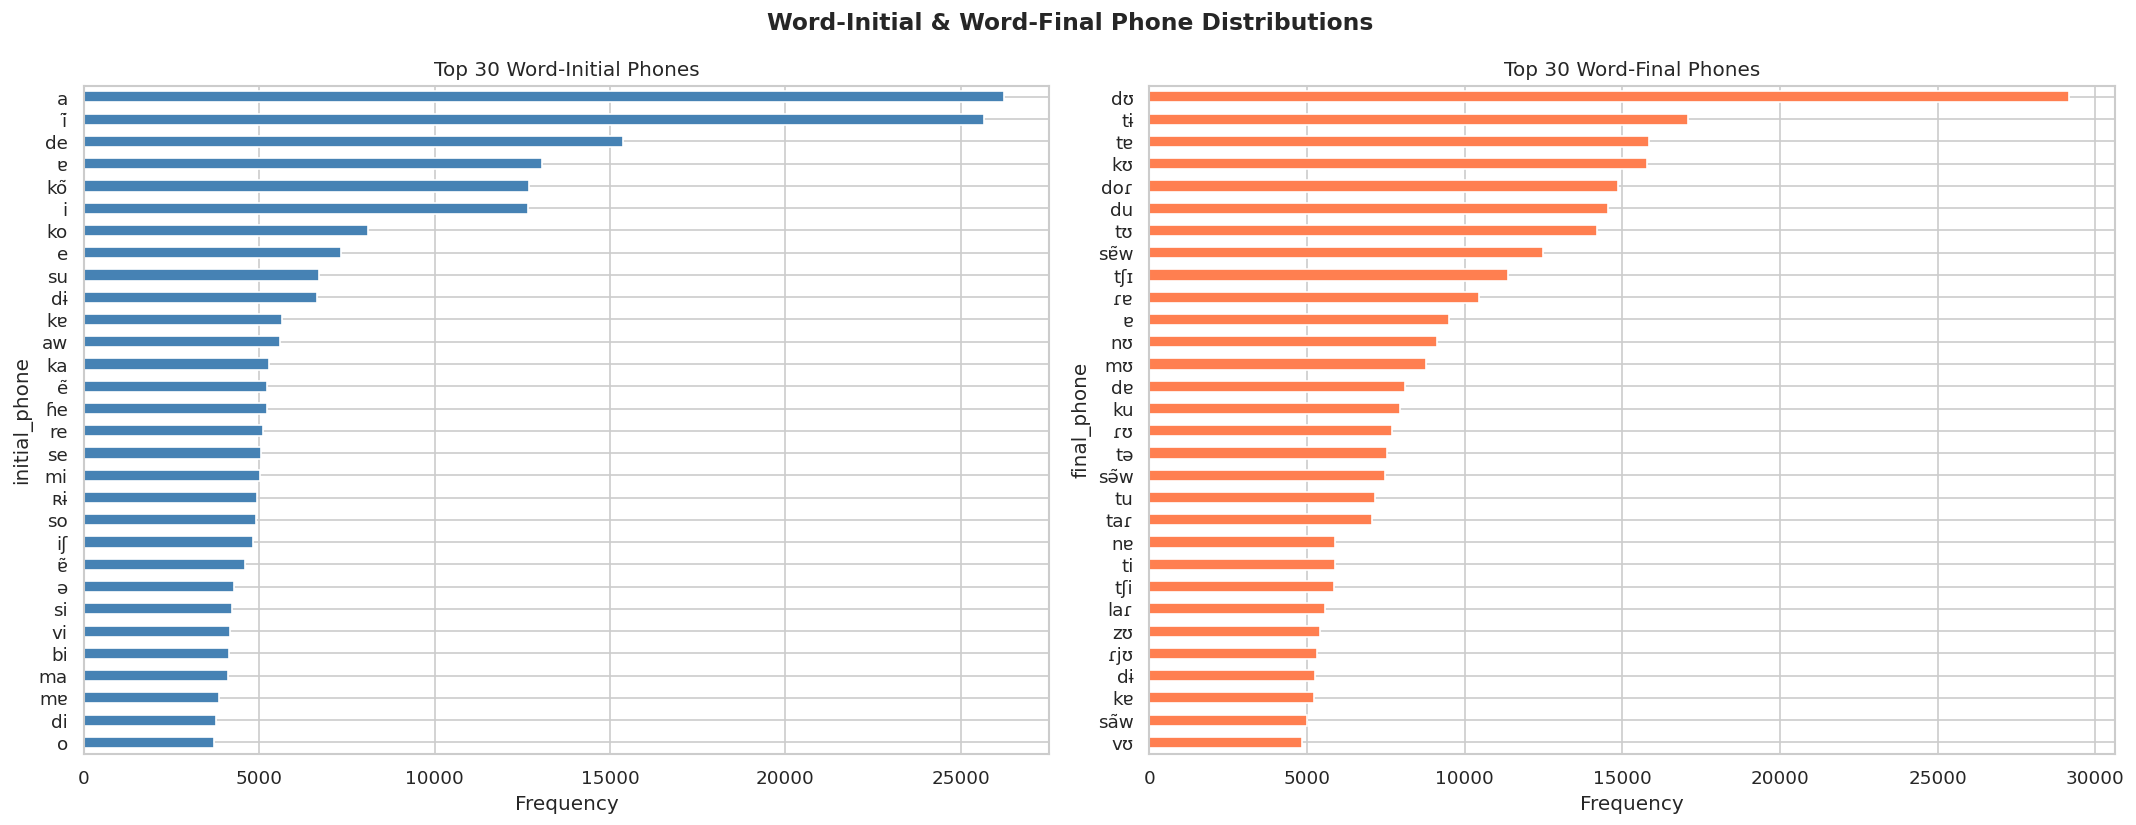

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Word-Initial & Word-Final Phone Distributions', fontsize=14, fontweight='bold')

ax = axes[0]
init_clean = df['initial_phone'].apply(strip_stress)
top_init = init_clean.value_counts().head(TOP_N)
top_init.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title(f'Top {TOP_N} Word-Initial Phones')
ax.set_xlabel('Frequency')
ax.invert_yaxis()

ax = axes[1]
final_clean = df['final_phone'].apply(strip_stress)
top_final = final_clean.value_counts().head(TOP_N)
top_final.plot(kind='barh', ax=ax, color='coral')
ax.set_title(f'Top {TOP_N} Word-Final Phones')
ax.set_xlabel('Frequency')
ax.invert_yaxis()

plt.tight_layout()
p = os.path.join(OUTPUT_DIR, "12_initial_final_phones.png")
plt.savefig(p, bbox_inches='tight')
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)

## 🧮 Section 13 — Summary Statistics Table

In [23]:
summary = {
    'Total rows': f"{len(df):,}",
    'Unique words': f"{df['word'].nunique():,}",
    'Unique phone sequences': f"{df['phones'].nunique():,}",
    'Unique phone types (base)': f"{len(set(all_phones_base)):,}",
    'Total phone tokens': f"{len(all_phones_raw):,}",
    'POS categories': f"{df['postag'].nunique()}",
    'Regional codes': f"{df['region_code'].nunique()}",
    'Entries with gender': f"{df['gender'].notna().sum():,}",
    'Avg word length (chars)': f"{df['word_len'].mean():.2f}",
    'Avg syllable count': f"{df['syll_count'].mean():.2f}",
    'Avg phone count': f"{df['phone_count'].mean():.2f}",
    'Avg phones/syllable': f"{df['phones_per_syll'].mean():.2f}",
    'Words with primary stress': f"{df['has_primary_stress'].mean()*100:.1f}%",
    'Single-pronunciation words': f"{pct_consistent:.1f}%",
    'Avg JSD across regions': f"{float(jsd_matrix[jsd_matrix>0].mean()):.4f}",
    'Max JSD between regions': f"{float(jsd_matrix.max()):.4f}",
}

summary_df = pd.DataFrame(list(summary.items()), columns=['Metric', 'Value'])
print(summary_df.to_string(index=False))

# Save as CSV
p_csv = os.path.join(OUTPUT_DIR, "summary_stats.csv")
summary_df.to_csv(p_csv, index=False)
if MLFLOW_TRACKING: mlflow.log_artifact(p_csv)
print(f"\nSaved summary: {p_csv}")

                    Metric     Value
                Total rows   616,716
              Unique words    53,349
    Unique phone sequences   358,017
 Unique phone types (base)     8,590
        Total phone tokens 2,401,533
            POS categories        10
            Regional codes        10
       Entries with gender   331,523
   Avg word length (chars)      9.20
        Avg syllable count      4.04
           Avg phone count      3.89
       Avg phones/syllable      0.97
 Words with primary stress     99.9%
Single-pronunciation words      0.4%
    Avg JSD across regions    0.5192
   Max JSD between regions    0.6545

Saved summary: ./analysis_output/summary_stats.csv


## 📊 Section 14 — Dashboard Overview (Single Figure)

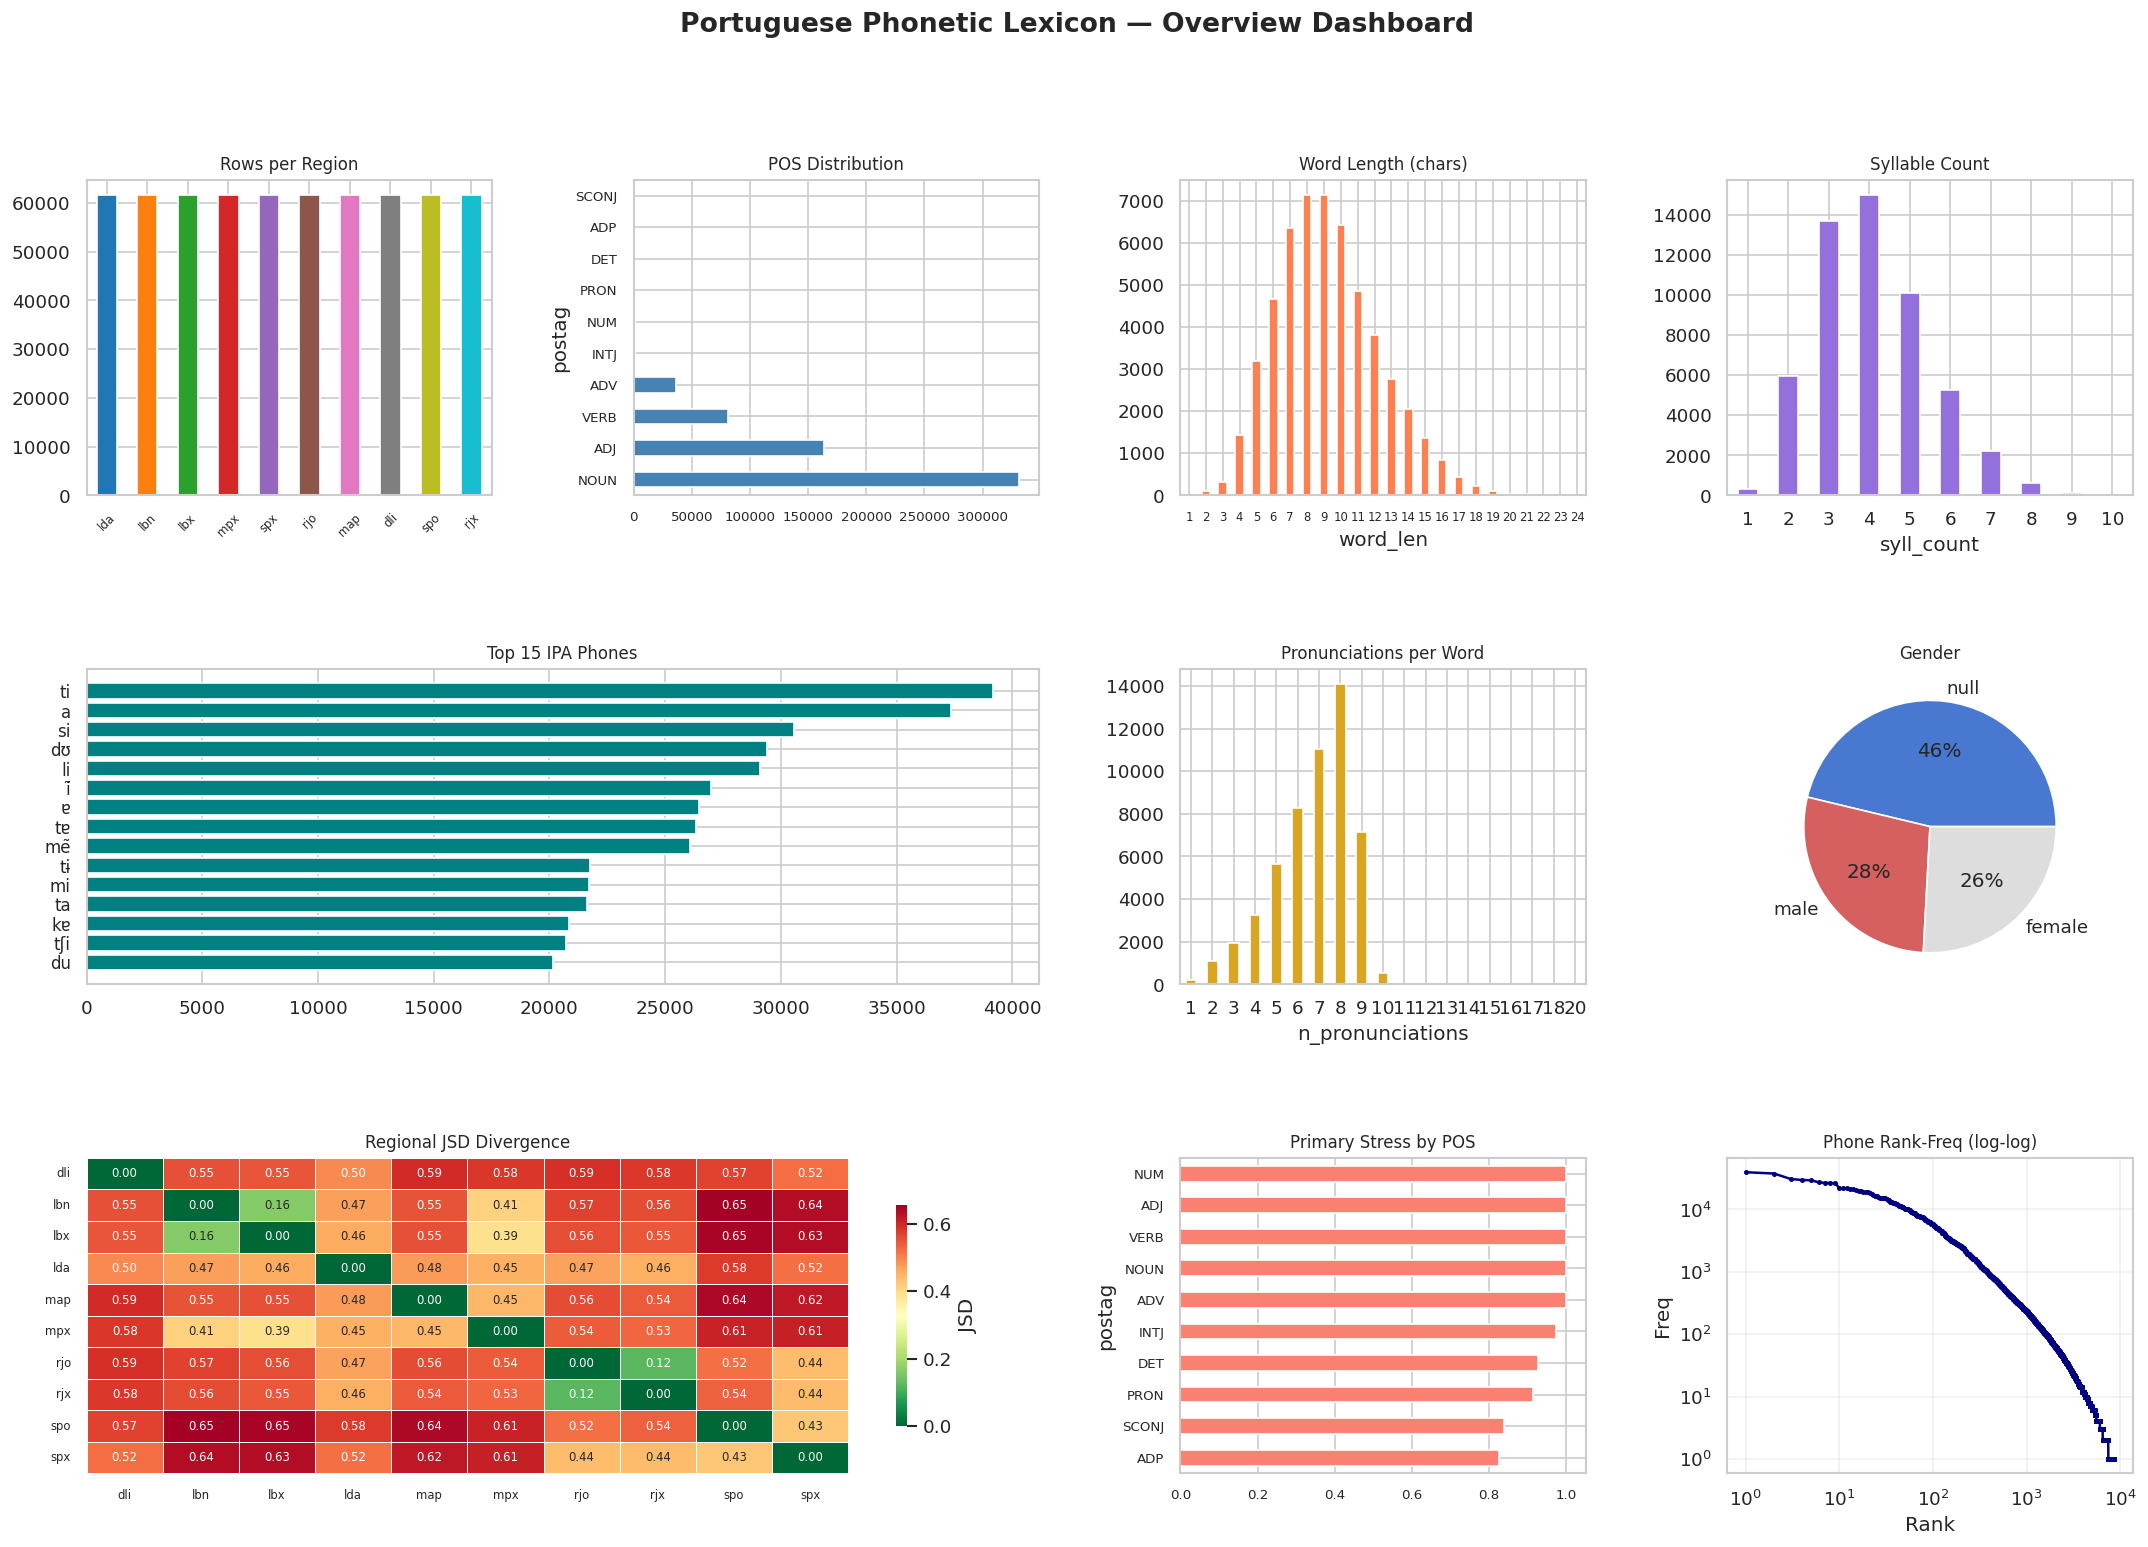

Dashboard saved: ./analysis_output/00_dashboard.png


In [24]:
fig = plt.figure(figsize=(22, 14))
gs  = gridspec.GridSpec(3, 4, figure=fig, hspace=0.55, wspace=0.35)
fig.suptitle('Portuguese Phonetic Lexicon — Overview Dashboard', fontsize=16, fontweight='bold', y=0.98)

# 1. Row count per region
ax = fig.add_subplot(gs[0, 0])
rc.plot(kind='bar', ax=ax, color=sns.color_palette('tab10', len(rc)))
ax.set_title('Rows per Region', fontsize=10)
ax.tick_params(axis='x', rotation=45, labelsize=7)
ax.set_xlabel('')

# 2. POS distribution
ax = fig.add_subplot(gs[0, 1])
pos_counts.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('POS Distribution', fontsize=10)
ax.tick_params(labelsize=8)

# 3. Word length
ax = fig.add_subplot(gs[0, 2])
words_df['word_len'].value_counts().sort_index().plot(kind='bar', ax=ax, color='coral')
ax.set_title('Word Length (chars)', fontsize=10)
ax.tick_params(axis='x', rotation=0, labelsize=7)

# 4. Syllable count
ax = fig.add_subplot(gs[0, 3])
words_df['syll_count'].value_counts().sort_index().plot(kind='bar', ax=ax, color='mediumpurple')
ax.set_title('Syllable Count', fontsize=10)
ax.tick_params(axis='x', rotation=0)

# 5. Top 15 phones
ax = fig.add_subplot(gs[1, 0:2])
tp15 = phone_freq.most_common(15)
ph15, cnt15 = zip(*tp15)
ax.barh(ph15[::-1], cnt15[::-1], color='teal')
ax.set_title('Top 15 IPA Phones', fontsize=10)
ax.tick_params(axis='y', labelsize=10)

# 6. G2P pronunciation count
ax = fig.add_subplot(gs[1, 2])
g2p_var['n_pronunciations'].value_counts().sort_index().plot(kind='bar', ax=ax, color='goldenrod')
ax.set_title('Pronunciations per Word', fontsize=10)
ax.tick_params(axis='x', rotation=0)

# 7. Gender pie
ax = fig.add_subplot(gs[1, 3])
ax.pie(gender_counts, labels=gender_counts.index, autopct='%1.0f%%',
       colors=['#4878CF','#D65F5F','#DDDDDD'])
ax.set_title('Gender', fontsize=10)

# 8. JSD heatmap (small)
ax = fig.add_subplot(gs[2, 0:2])
sns.heatmap(jsd_df, ax=ax, cmap='RdYlGn_r', annot=True, fmt='.2f',
            linewidths=0.4, annot_kws={'size': 7},
            cbar_kws={'label': 'JSD', 'shrink': 0.7})
ax.set_title('Regional JSD Divergence', fontsize=10)
ax.tick_params(labelsize=7)

# 9. Stress by POS
ax = fig.add_subplot(gs[2, 2])
stress_by_pos.plot(kind='barh', ax=ax, color='salmon')
ax.set_title('Primary Stress by POS', fontsize=10)
ax.tick_params(labelsize=8)

# 10. Rank-frequency
ax = fig.add_subplot(gs[2, 3])
ax.loglog(ranks, freqs, 'o-', markersize=2, color='navy')
ax.set_title('Phone Rank-Freq (log-log)', fontsize=10)
ax.set_xlabel('Rank')
ax.set_ylabel('Freq')
ax.grid(True, alpha=0.3)

p = os.path.join(OUTPUT_DIR, "00_dashboard.png")
plt.savefig(p, bbox_inches='tight', dpi=FIG_DPI)
plt.show()
if MLFLOW_TRACKING: mlflow.log_artifact(p)
print("Dashboard saved:", p)

## 🏁 Finish MLflow Run

In [26]:
if MLFLOW_TRACKING:
    mlflow.log_metrics({
        "unique_phones": len(set(all_phones_base)),
        "unique_words": int(df['word'].nunique()),
        "total_rows": len(df),
    })
    mlflow.end_run()
    print(f"MLflow run complete. UI: mlflow ui --backend-store-uri {MLFLOW_URI}")

print("\n✅ Analysis complete!")
print(f"All artifacts saved to: {OUTPUT_DIR}")

import glob
for f in sorted(glob.glob(os.path.join(OUTPUT_DIR, "*"))):
    size = os.path.getsize(f)
    print(f"  {os.path.basename(f):45s}  {size/1024:.1f} KB")

MLflow run complete. UI: mlflow ui --backend-store-uri ./mlruns

✅ Analysis complete!
All artifacts saved to: ./analysis_output
  00_dashboard.png                               254.6 KB
  01_lexicon_stats.png                           165.1 KB
  02_pos_gender.png                              73.3 KB
  03_regional.png                                86.1 KB
  04_phone_inventory.png                         69.1 KB
  05_regional_phone_heatmap.png                  47.6 KB
  06_jsd_divergence.png                          161.3 KB
  07_vowels_consonants.png                       62.9 KB
  08_stress_patterns.png                         79.5 KB
  09_phone_bigrams.png                           50.4 KB
  10_g2p_consistency.png                         64.4 KB
  11_pos_region_interaction.png                  115.5 KB
  12_initial_final_phones.png                    74.2 KB
  lexicon_cache.parquet                          8817.9 KB
  summary_stats.csv                              0.4 KB
